# Tweets data wrangling
#### Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import yaml
import json
import pprint
import tweepy
import time

## Gather
### Twitter Archive

In [2]:
# Create twitter archive DataFrame from the associated csv file
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Tweets image prediction

In [3]:
image_pred_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = image_pred_url.split('/')[-1]

if not os.path.isfile(file_name):
    # Retrieve the file content from the web
    response = requests.get(image_pred_url)
    # And save it in a tsv file
    with open(file_name, mode='wb') as file:
        file.write(response.content)
        
# Create tweet image prediction DataFrame from the downloaded tsv file
df_tweets_img_pred = pd.read_csv(file_name, sep='\t')
df_tweets_img_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Tweeter API

In [4]:
# Load the API keys from the yaml file
with open('twitter_api_keys.yaml', mode='r') as file:
    twitter_cred = yaml.load(file, Loader=yaml.FullLoader)
    
consumer_key = twitter_cred['APIKEY']
consumer_secret = twitter_cred['APIKEYSECRET']
access_token = twitter_cred['ACCESSTOKEN']
access_secret = twitter_cred['ACCESSTOKENSECRET']

# Open a tweepy API object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,
                 wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)

tweet_json_path = 'tweet_json.txt'
overwrite_json_file = False
if overwrite_json_file or not os.path.isfile(tweet_json_path):
    with open(tweet_json_path, 'w') as outfile:
        for idx, tweet_id in df_twitter_archive.tweet_id.iteritems():
            start_time = time.time()
            try:
                tweet_status = api.get_status(tweet_id, tweet_mode='extended')
                if idx > 0:
                    outfile.write("\n")
                json.dump(tweet_status._json, outfile)
                
                print("Tweet {} retrieved from Twitter API in {:.3f} seconds".format(tweet_id, time.time() - start_time))
            except tweepy.TweepError as e:
                print("Tweet {} couldn\'t be retrieved from Twitter API with error: \"{}\"".format(tweet_id, e))               

Tweet 892420643555336193 retrieved from Twitter API in 0.340 seconds
Tweet 892177421306343426 retrieved from Twitter API in 0.282 seconds
Tweet 891815181378084864 retrieved from Twitter API in 0.286 seconds
Tweet 891689557279858688 retrieved from Twitter API in 0.299 seconds
Tweet 891327558926688256 retrieved from Twitter API in 0.306 seconds
Tweet 891087950875897856 retrieved from Twitter API in 0.284 seconds
Tweet 890971913173991426 retrieved from Twitter API in 0.286 seconds
Tweet 890729181411237888 retrieved from Twitter API in 0.301 seconds
Tweet 890609185150312448 retrieved from Twitter API in 0.289 seconds
Tweet 890240255349198849 retrieved from Twitter API in 0.282 seconds
Tweet 890006608113172480 retrieved from Twitter API in 0.268 seconds
Tweet 889880896479866881 retrieved from Twitter API in 0.288 seconds
Tweet 889665388333682689 retrieved from Twitter API in 0.289 seconds
Tweet 889638837579907072 retrieved from Twitter API in 0.286 seconds
Tweet 889531135344209921 retrieved

Tweet 870374049280663552 retrieved from Twitter API in 0.278 seconds
Tweet 870308999962521604 retrieved from Twitter API in 0.288 seconds
Tweet 870063196459192321 retrieved from Twitter API in 0.272 seconds
Tweet 869988702071779329 couldn't be retrieved from Twitter API with error: "[{'code': 144, 'message': 'No status found with that ID.'}]"
Tweet 869772420881756160 retrieved from Twitter API in 0.284 seconds
Tweet 869702957897576449 retrieved from Twitter API in 0.287 seconds
Tweet 869596645499047938 retrieved from Twitter API in 0.289 seconds
Tweet 869227993411051520 retrieved from Twitter API in 0.280 seconds
Tweet 868880397819494401 retrieved from Twitter API in 0.286 seconds
Tweet 868639477480148993 retrieved from Twitter API in 0.280 seconds
Tweet 868622495443632128 retrieved from Twitter API in 0.306 seconds
Tweet 868552278524837888 retrieved from Twitter API in 0.283 seconds
Tweet 867900495410671616 retrieved from Twitter API in 0.287 seconds
Tweet 867774946302451713 retrieved

Tweet 848212111729840128 retrieved from Twitter API in 0.293 seconds
Tweet 847978865427394560 retrieved from Twitter API in 0.304 seconds
Tweet 847971574464610304 retrieved from Twitter API in 0.291 seconds
Tweet 847962785489326080 retrieved from Twitter API in 0.285 seconds
Tweet 847842811428974592 retrieved from Twitter API in 0.291 seconds
Tweet 847617282490613760 retrieved from Twitter API in 0.300 seconds
Tweet 847606175596138505 retrieved from Twitter API in 0.281 seconds
Tweet 847251039262605312 retrieved from Twitter API in 0.291 seconds
Tweet 847157206088847362 retrieved from Twitter API in 0.287 seconds
Tweet 847116187444137987 retrieved from Twitter API in 0.288 seconds
Tweet 846874817362120707 retrieved from Twitter API in 0.289 seconds
Tweet 846514051647705089 retrieved from Twitter API in 0.293 seconds
Tweet 846505985330044928 retrieved from Twitter API in 0.301 seconds
Tweet 846153765933735936 retrieved from Twitter API in 0.305 seconds
Tweet 846139713627017216 retrieved

Tweet 832040443403784192 retrieved from Twitter API in 0.293 seconds
Tweet 832032802820481025 retrieved from Twitter API in 0.293 seconds
Tweet 831939777352105988 retrieved from Twitter API in 0.267 seconds
Tweet 831926988323639298 retrieved from Twitter API in 0.284 seconds
Tweet 831911600680497154 retrieved from Twitter API in 0.292 seconds
Tweet 831670449226514432 retrieved from Twitter API in 0.327 seconds
Tweet 831650051525054464 retrieved from Twitter API in 0.335 seconds
Tweet 831552930092285952 retrieved from Twitter API in 0.282 seconds
Tweet 831322785565769729 retrieved from Twitter API in 0.279 seconds
Tweet 831315979191906304 retrieved from Twitter API in 0.292 seconds
Tweet 831309418084069378 retrieved from Twitter API in 0.287 seconds
Tweet 831262627380748289 retrieved from Twitter API in 0.291 seconds
Tweet 830956169170665475 retrieved from Twitter API in 0.294 seconds
Tweet 830583320585068544 retrieved from Twitter API in 0.279 seconds
Tweet 830173239259324417 retrieved

Tweet 817777686764523521 retrieved from Twitter API in 0.282 seconds
Tweet 817536400337801217 retrieved from Twitter API in 0.316 seconds
Tweet 817502432452313088 retrieved from Twitter API in 0.295 seconds
Tweet 817423860136083457 retrieved from Twitter API in 0.277 seconds
Tweet 817415592588222464 retrieved from Twitter API in 0.278 seconds
Tweet 817181837579653120 retrieved from Twitter API in 0.289 seconds
Tweet 817171292965273600 retrieved from Twitter API in 0.283 seconds
Tweet 817120970343411712 retrieved from Twitter API in 0.331 seconds
Tweet 817056546584727552 retrieved from Twitter API in 0.295 seconds
Tweet 816829038950027264 retrieved from Twitter API in 0.290 seconds
Tweet 816816676327063552 retrieved from Twitter API in 0.278 seconds
Tweet 816697700272001025 retrieved from Twitter API in 0.287 seconds
Tweet 816450570814898180 retrieved from Twitter API in 0.293 seconds
Tweet 816336735214911488 retrieved from Twitter API in 0.269 seconds
Tweet 816091915477250048 retrieved

Tweet 800855607700029440 retrieved from Twitter API in 0.390 seconds
Tweet 800751577355128832 retrieved from Twitter API in 0.283 seconds
Tweet 800513324630806528 retrieved from Twitter API in 0.281 seconds
Tweet 800459316964663297 retrieved from Twitter API in 0.269 seconds
Tweet 800443802682937345 retrieved from Twitter API in 0.292 seconds
Tweet 800388270626521089 retrieved from Twitter API in 0.273 seconds
Tweet 800188575492947969 retrieved from Twitter API in 0.301 seconds
Tweet 800141422401830912 retrieved from Twitter API in 0.293 seconds
Tweet 800018252395122689 retrieved from Twitter API in 0.293 seconds
Tweet 799774291445383169 retrieved from Twitter API in 0.289 seconds
Tweet 799757965289017345 retrieved from Twitter API in 0.290 seconds
Tweet 799422933579902976 retrieved from Twitter API in 0.272 seconds
Tweet 799308762079035393 retrieved from Twitter API in 0.293 seconds
Tweet 799297110730567681 retrieved from Twitter API in 0.287 seconds
Tweet 799063482566066176 retrieved

Tweet 786664955043049472 retrieved from Twitter API in 0.282 seconds
Tweet 786595970293370880 retrieved from Twitter API in 0.287 seconds
Tweet 786363235746385920 retrieved from Twitter API in 0.301 seconds
Tweet 786286427768250368 retrieved from Twitter API in 0.286 seconds
Tweet 786233965241827333 retrieved from Twitter API in 0.284 seconds
Tweet 786051337297522688 retrieved from Twitter API in 0.274 seconds
Tweet 786036967502913536 retrieved from Twitter API in 0.341 seconds
Tweet 785927819176054784 retrieved from Twitter API in 0.287 seconds
Tweet 785872687017132033 retrieved from Twitter API in 0.314 seconds
Tweet 785639753186217984 retrieved from Twitter API in 0.292 seconds
Tweet 785533386513321988 retrieved from Twitter API in 0.279 seconds
Tweet 785515384317313025 retrieved from Twitter API in 0.276 seconds
Tweet 785264754247995392 retrieved from Twitter API in 0.285 seconds
Tweet 785170936622350336 retrieved from Twitter API in 0.286 seconds
Tweet 784826020293709826 retrieved

Tweet 771102124360998913 retrieved from Twitter API in 0.301 seconds
Tweet 771014301343748096 retrieved from Twitter API in 0.277 seconds
Tweet 771004394259247104 couldn't be retrieved from Twitter API with error: "[{'code': 179, 'message': 'Sorry, you are not authorized to see this status.'}]"
Tweet 770787852854652928 retrieved from Twitter API in 0.287 seconds
Tweet 770772759874076672 retrieved from Twitter API in 0.287 seconds
Tweet 770743923962707968 couldn't be retrieved from Twitter API with error: "[{'code': 144, 'message': 'No status found with that ID.'}]"
Tweet 770655142660169732 retrieved from Twitter API in 0.289 seconds
Tweet 770414278348247044 retrieved from Twitter API in 0.290 seconds
Tweet 770293558247038976 retrieved from Twitter API in 0.307 seconds
Tweet 770093767776997377 retrieved from Twitter API in 0.301 seconds
Tweet 770069151037685760 retrieved from Twitter API in 0.285 seconds
Tweet 769940425801170949 retrieved from Twitter API in 0.286 seconds
Tweet 76969546

Rate limit reached. Sleeping for: 638


Tweet 758740312047005698 retrieved from Twitter API in 643.484 seconds
Tweet 758474966123810816 retrieved from Twitter API in 0.326 seconds
Tweet 758467244762497024 retrieved from Twitter API in 0.280 seconds
Tweet 758405701903519748 retrieved from Twitter API in 0.277 seconds
Tweet 758355060040593408 retrieved from Twitter API in 0.322 seconds
Tweet 758099635764359168 retrieved from Twitter API in 0.271 seconds
Tweet 758041019896193024 retrieved from Twitter API in 0.300 seconds
Tweet 757741869644341248 retrieved from Twitter API in 0.290 seconds
Tweet 757729163776290825 retrieved from Twitter API in 0.285 seconds
Tweet 757725642876129280 retrieved from Twitter API in 0.280 seconds
Tweet 757611664640446465 retrieved from Twitter API in 0.298 seconds
Tweet 757597904299253760 retrieved from Twitter API in 0.294 seconds
Tweet 757596066325864448 retrieved from Twitter API in 0.282 seconds
Tweet 757400162377592832 retrieved from Twitter API in 0.281 seconds
Tweet 757393109802180609 retriev

Tweet 746818907684614144 retrieved from Twitter API in 0.281 seconds
Tweet 746790600704425984 retrieved from Twitter API in 0.279 seconds
Tweet 746757706116112384 retrieved from Twitter API in 0.277 seconds
Tweet 746726898085036033 retrieved from Twitter API in 0.279 seconds
Tweet 746542875601690625 retrieved from Twitter API in 0.280 seconds
Tweet 746521445350707200 retrieved from Twitter API in 0.285 seconds
Tweet 746507379341139972 retrieved from Twitter API in 0.281 seconds
Tweet 746369468511756288 retrieved from Twitter API in 0.281 seconds
Tweet 746131877086527488 retrieved from Twitter API in 0.281 seconds
Tweet 746056683365994496 retrieved from Twitter API in 0.287 seconds
Tweet 745789745784041472 retrieved from Twitter API in 0.286 seconds
Tweet 745712589599014916 retrieved from Twitter API in 0.270 seconds
Tweet 745433870967832576 retrieved from Twitter API in 0.283 seconds
Tweet 745422732645535745 retrieved from Twitter API in 0.306 seconds
Tweet 745314880350101504 retrieved

Tweet 728046963732717569 retrieved from Twitter API in 0.273 seconds
Tweet 728035342121635841 retrieved from Twitter API in 0.282 seconds
Tweet 728015554473250816 retrieved from Twitter API in 0.274 seconds
Tweet 727685679342333952 retrieved from Twitter API in 0.285 seconds
Tweet 727644517743104000 retrieved from Twitter API in 0.286 seconds
Tweet 727524757080539137 retrieved from Twitter API in 0.281 seconds
Tweet 727314416056803329 retrieved from Twitter API in 0.280 seconds
Tweet 727286334147182592 retrieved from Twitter API in 0.303 seconds
Tweet 727175381690781696 retrieved from Twitter API in 0.282 seconds
Tweet 727155742655025152 retrieved from Twitter API in 0.283 seconds
Tweet 726935089318363137 retrieved from Twitter API in 0.275 seconds
Tweet 726887082820554753 retrieved from Twitter API in 0.287 seconds
Tweet 726828223124897792 retrieved from Twitter API in 0.270 seconds
Tweet 726224900189511680 retrieved from Twitter API in 0.276 seconds
Tweet 725842289046749185 retrieved

Tweet 710588934686908417 retrieved from Twitter API in 0.296 seconds
Tweet 710296729921429505 retrieved from Twitter API in 0.287 seconds
Tweet 710283270106132480 retrieved from Twitter API in 0.305 seconds
Tweet 710272297844797440 retrieved from Twitter API in 0.323 seconds
Tweet 710269109699739648 retrieved from Twitter API in 0.282 seconds
Tweet 710153181850935296 retrieved from Twitter API in 0.311 seconds
Tweet 710140971284037632 retrieved from Twitter API in 0.302 seconds
Tweet 710117014656950272 retrieved from Twitter API in 0.270 seconds
Tweet 709918798883774466 retrieved from Twitter API in 0.301 seconds
Tweet 709901256215666688 retrieved from Twitter API in 0.276 seconds
Tweet 709852847387627521 retrieved from Twitter API in 0.285 seconds
Tweet 709566166965075968 retrieved from Twitter API in 0.295 seconds
Tweet 709556954897764353 retrieved from Twitter API in 0.280 seconds
Tweet 709519240576036864 retrieved from Twitter API in 0.274 seconds
Tweet 709449600415961088 retrieved

Tweet 701889187134500865 retrieved from Twitter API in 0.280 seconds
Tweet 701805642395348998 retrieved from Twitter API in 0.292 seconds
Tweet 701601587219795968 retrieved from Twitter API in 0.291 seconds
Tweet 701570477911896070 retrieved from Twitter API in 0.287 seconds
Tweet 701545186879471618 retrieved from Twitter API in 0.290 seconds
Tweet 701214700881756160 retrieved from Twitter API in 0.284 seconds
Tweet 700890391244103680 retrieved from Twitter API in 0.289 seconds
Tweet 700864154249383937 retrieved from Twitter API in 0.276 seconds
Tweet 700847567345688576 retrieved from Twitter API in 0.293 seconds
Tweet 700796979434098688 retrieved from Twitter API in 0.278 seconds
Tweet 700747788515020802 retrieved from Twitter API in 0.284 seconds
Tweet 700518061187723268 retrieved from Twitter API in 0.287 seconds
Tweet 700505138482569216 retrieved from Twitter API in 0.267 seconds
Tweet 700462010979500032 retrieved from Twitter API in 0.342 seconds
Tweet 700167517596164096 retrieved

Tweet 692568918515392513 retrieved from Twitter API in 0.281 seconds
Tweet 692535307825213440 retrieved from Twitter API in 0.293 seconds
Tweet 692530551048294401 retrieved from Twitter API in 0.281 seconds
Tweet 692423280028966913 retrieved from Twitter API in 0.286 seconds
Tweet 692417313023332352 retrieved from Twitter API in 0.315 seconds
Tweet 692187005137076224 retrieved from Twitter API in 0.289 seconds
Tweet 692158366030913536 retrieved from Twitter API in 0.336 seconds
Tweet 692142790915014657 retrieved from Twitter API in 0.294 seconds
Tweet 692041934689402880 retrieved from Twitter API in 0.286 seconds
Tweet 692017291282812928 retrieved from Twitter API in 0.278 seconds
Tweet 691820333922455552 retrieved from Twitter API in 0.279 seconds
Tweet 691793053716221953 retrieved from Twitter API in 0.275 seconds
Tweet 691756958957883396 retrieved from Twitter API in 0.298 seconds
Tweet 691675652215414786 retrieved from Twitter API in 0.288 seconds
Tweet 691483041324204033 retrieved

Tweet 685315239903100929 retrieved from Twitter API in 0.299 seconds
Tweet 685307451701334016 retrieved from Twitter API in 0.293 seconds
Tweet 685268753634967552 retrieved from Twitter API in 0.281 seconds
Tweet 685198997565345792 retrieved from Twitter API in 0.276 seconds
Tweet 685169283572338688 retrieved from Twitter API in 0.274 seconds
Tweet 684969860808454144 retrieved from Twitter API in 0.269 seconds
Tweet 684959798585110529 retrieved from Twitter API in 0.284 seconds
Tweet 684940049151070208 retrieved from Twitter API in 0.283 seconds
Tweet 684926975086034944 retrieved from Twitter API in 0.274 seconds
Tweet 684914660081053696 retrieved from Twitter API in 0.273 seconds
Tweet 684902183876321280 retrieved from Twitter API in 0.283 seconds
Tweet 684880619965411328 retrieved from Twitter API in 0.288 seconds
Tweet 684830982659280897 retrieved from Twitter API in 0.292 seconds
Tweet 684800227459624960 retrieved from Twitter API in 0.283 seconds
Tweet 684594889858887680 retrieved

Tweet 679844490799091713 retrieved from Twitter API in 0.276 seconds
Tweet 679828447187857408 retrieved from Twitter API in 0.275 seconds
Tweet 679777920601223168 retrieved from Twitter API in 0.308 seconds
Tweet 679736210798047232 retrieved from Twitter API in 0.293 seconds
Tweet 679729593985699840 retrieved from Twitter API in 0.281 seconds
Tweet 679722016581222400 retrieved from Twitter API in 0.266 seconds
Tweet 679530280114372609 retrieved from Twitter API in 0.286 seconds
Tweet 679527802031484928 retrieved from Twitter API in 0.304 seconds
Tweet 679511351870550016 retrieved from Twitter API in 0.307 seconds
Tweet 679503373272485890 retrieved from Twitter API in 0.316 seconds
Tweet 679475951516934144 retrieved from Twitter API in 0.284 seconds
Tweet 679462823135686656 retrieved from Twitter API in 0.281 seconds
Tweet 679405845277462528 retrieved from Twitter API in 0.281 seconds
Tweet 679158373988876288 retrieved from Twitter API in 0.290 seconds
Tweet 679148763231985668 retrieved

Rate limit reached. Sleeping for: 641


Tweet 676975532580409345 retrieved from Twitter API in 646.545 seconds
Tweet 676957860086095872 retrieved from Twitter API in 0.301 seconds
Tweet 676949632774234114 retrieved from Twitter API in 0.293 seconds
Tweet 676948236477857792 retrieved from Twitter API in 0.286 seconds
Tweet 676946864479084545 retrieved from Twitter API in 0.294 seconds
Tweet 676942428000112642 retrieved from Twitter API in 0.286 seconds
Tweet 676936541936185344 retrieved from Twitter API in 0.285 seconds
Tweet 676916996760600576 retrieved from Twitter API in 0.294 seconds
Tweet 676897532954456065 retrieved from Twitter API in 0.280 seconds
Tweet 676864501615042560 retrieved from Twitter API in 0.294 seconds
Tweet 676821958043033607 retrieved from Twitter API in 0.283 seconds
Tweet 676819651066732545 retrieved from Twitter API in 0.349 seconds
Tweet 676811746707918848 retrieved from Twitter API in 0.285 seconds
Tweet 676776431406465024 retrieved from Twitter API in 0.283 seconds
Tweet 676617503762681856 retriev

Tweet 674269164442398721 retrieved from Twitter API in 0.285 seconds
Tweet 674265582246694913 retrieved from Twitter API in 0.279 seconds
Tweet 674262580978937856 retrieved from Twitter API in 0.284 seconds
Tweet 674255168825880576 retrieved from Twitter API in 0.294 seconds
Tweet 674082852460433408 retrieved from Twitter API in 0.352 seconds
Tweet 674075285688614912 retrieved from Twitter API in 0.290 seconds
Tweet 674063288070742018 retrieved from Twitter API in 0.274 seconds
Tweet 674053186244734976 retrieved from Twitter API in 0.284 seconds
Tweet 674051556661161984 retrieved from Twitter API in 0.289 seconds
Tweet 674045139690631169 retrieved from Twitter API in 0.327 seconds
Tweet 674042553264685056 retrieved from Twitter API in 0.277 seconds
Tweet 674038233588723717 retrieved from Twitter API in 0.278 seconds
Tweet 674036086168010753 retrieved from Twitter API in 0.289 seconds
Tweet 674024893172875264 retrieved from Twitter API in 0.292 seconds
Tweet 674019345211760640 retrieved

Tweet 671550332464455680 retrieved from Twitter API in 0.281 seconds
Tweet 671547767500775424 retrieved from Twitter API in 0.279 seconds
Tweet 671544874165002241 retrieved from Twitter API in 0.278 seconds
Tweet 671542985629241344 retrieved from Twitter API in 0.281 seconds
Tweet 671538301157904385 retrieved from Twitter API in 0.309 seconds
Tweet 671536543010570240 retrieved from Twitter API in 0.284 seconds
Tweet 671533943490011136 retrieved from Twitter API in 0.277 seconds
Tweet 671528761649688577 retrieved from Twitter API in 0.279 seconds
Tweet 671520732782923777 retrieved from Twitter API in 0.297 seconds
Tweet 671518598289059840 retrieved from Twitter API in 0.299 seconds
Tweet 671511350426865664 retrieved from Twitter API in 0.279 seconds
Tweet 671504605491109889 retrieved from Twitter API in 0.286 seconds
Tweet 671497587707535361 retrieved from Twitter API in 0.281 seconds
Tweet 671488513339211776 retrieved from Twitter API in 0.291 seconds
Tweet 671486386088865792 retrieved

Tweet 669583744538451968 retrieved from Twitter API in 0.321 seconds
Tweet 669573570759163904 retrieved from Twitter API in 0.293 seconds
Tweet 669571471778410496 retrieved from Twitter API in 0.304 seconds
Tweet 669567591774625800 retrieved from Twitter API in 0.284 seconds
Tweet 669564461267722241 retrieved from Twitter API in 0.305 seconds
Tweet 669393256313184256 retrieved from Twitter API in 0.286 seconds
Tweet 669375718304980992 retrieved from Twitter API in 0.293 seconds
Tweet 669371483794317312 retrieved from Twitter API in 0.284 seconds
Tweet 669367896104181761 retrieved from Twitter API in 0.270 seconds
Tweet 669363888236994561 retrieved from Twitter API in 0.284 seconds
Tweet 669359674819481600 retrieved from Twitter API in 0.280 seconds
Tweet 669354382627049472 retrieved from Twitter API in 0.294 seconds
Tweet 669353438988365824 retrieved from Twitter API in 0.269 seconds
Tweet 669351434509529089 retrieved from Twitter API in 0.291 seconds
Tweet 669328503091937280 retrieved

Tweet 667443425659232256 retrieved from Twitter API in 0.280 seconds
Tweet 667437278097252352 retrieved from Twitter API in 0.275 seconds
Tweet 667435689202614272 retrieved from Twitter API in 0.276 seconds
Tweet 667405339315146752 retrieved from Twitter API in 0.326 seconds
Tweet 667393430834667520 retrieved from Twitter API in 0.279 seconds
Tweet 667369227918143488 retrieved from Twitter API in 0.292 seconds
Tweet 667211855547486208 retrieved from Twitter API in 0.292 seconds
Tweet 667200525029539841 retrieved from Twitter API in 0.287 seconds
Tweet 667192066997374976 retrieved from Twitter API in 0.287 seconds
Tweet 667188689915760640 retrieved from Twitter API in 0.289 seconds
Tweet 667182792070062081 retrieved from Twitter API in 0.285 seconds
Tweet 667177989038297088 retrieved from Twitter API in 0.320 seconds
Tweet 667176164155375616 retrieved from Twitter API in 0.280 seconds
Tweet 667174963120574464 retrieved from Twitter API in 0.280 seconds
Tweet 667171260800061440 retrieved

In [5]:
# Open the json txt file and extract the needed infos from the json data for each tweet saved
if os.path.isfile(tweet_json_path):
    with open(tweet_json_path, 'r') as json_file:
        # Create some columns for the new values retrieved from Twitter API
        df_twitter_archive['retweet_count'] = pd.Series(np.nan, dtype='Int64')
        df_twitter_archive['favorite_count'] = pd.Series(np.nan, dtype='Int64')
        
        # Iterate over each line in the txt file until the end of the file
        json_line = json_file.readline()
        while json_line:
            # Retrieve info from the json data structure
            tweet_json_data = json.loads(json_line)
            tweet_id = tweet_json_data['id']
            retweet_count = tweet_json_data['retweet_count']
            favorite_count = tweet_json_data['favorite_count']
            
            # And copy it in the Twitter archive DataFrame
            df_twitter_archive.loc[df_twitter_archive.tweet_id == tweet_id, 'retweet_count'] = retweet_count
            df_twitter_archive.loc[df_twitter_archive.tweet_id == tweet_id, 'favorite_count'] = favorite_count
            
            json_line = json_file.readline()

In [6]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

## Assess
### Data Quality
#### df_twitter_archive

- source column should be a human readable category instead of non readable HTML code
- timestamp and retweeted_status_timestamp should be a DateTime instead of a string
- Some rating_numerator and rating_denominator don't follow the Dog Rates convention
- \*_status_id and \*_user_id should be int instead of float
- p1 (dog's race name) string should be formated the same way
- Many dogs have 'a' as name
- Some dogs have multiple dog stage (doggo, pupper or puppo)
- Some tweets have missing retweet_count and favorite_count
- There are less tweets rows in df_tweets_img_pred as in df_twitter_archive

#### df_tweets_img_pred


### Data tidiness

- doggo, pupper and puppo should be one categorical variable
- Dog breed with highest probability and and dog flag variables from df_tweets_img_pred should be part of df_twitter_archive

In [7]:
df_twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
1603,685943807276412928,NaN,NaN,2016-01-09 21:58:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is the newly formed pupper a capella grou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685943807...,8,10,the,None,None,pupper,None,569,1575
1954,673656262056419329,NaN,NaN,2015-12-07 00:12:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Albert AKA King Banana Peel. He's a ki...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673656262...,10,10,Albert,None,None,pupper,None,219,679
1564,688116655151435777,NaN,NaN,2016-01-15 21:52:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please send dogs. I'm tired of seeing other st...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/688116655...,10,10,None,None,None,None,None,743,2736
1726,680055455951884288,NaN,NaN,2015-12-24 16:00:30 +0000,"<a href=""https://about.twitter.com/products/tw...","Meet Sammy. At first I was like ""that's a snow...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/680055455...,10,10,Sammy,None,None,None,None,<NA>,<NA>
639,793256262322548741,NaN,NaN,2016-11-01 01:00:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Oh h*ck look at this spookling right here. Fri...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793256262...,12,10,None,None,None,None,None,8250,19804
2125,670361874861563904,NaN,NaN,2015-11-27 22:01:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Rich Mahogany Seltzer named Cherokee...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670361874...,9,10,a,None,None,None,None,60,310
1507,691675652215414786,NaN,NaN,2016-01-25 17:35:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Richie and Plip. They are the best of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/691675652...,10,10,Richie,None,None,None,None,492,1891
1738,679527802031484928,NaN,NaN,2015-12-23 05:03:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This little pupper just arrived. 11/10 would s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679527802...,11,10,None,None,None,pupper,None,690,2537
521,809920764300447744,NaN,NaN,2016-12-17 00:38:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Please only send in dogs. We only rate dogs, n...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/809920764...,10,10,None,None,None,None,None,3884,15401
804,772117678702071809,NaN,NaN,2016-09-03 17:02:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jack. He's a Clemson pup. Appears to be r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772117678...,12,10,Jack,None,None,None,None,722,3700


In [8]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [9]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000,2331.000000,2331.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433,2608.168168,7346.697555
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237,4412.586286,11409.760061
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000,1.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000,529.000000,1276.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000,1218.000000,3190.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000,3027.500000,8990.500000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000,74917.000000,151353.000000


In [10]:
df_twitter_archive.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Cooper      11
          ... 
Petrick      1
Tess         1
Lugan        1
Billl        1
Kaia         1
Name: name, Length: 957, dtype: int64

In [11]:
df_twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [12]:
df_twitter_archive[['doggo', 'pupper', 'puppo']].value_counts()

doggo  pupper  puppo
None   None    None     1985
       pupper  None      245
doggo  None    None       84
None   None    puppo      29
doggo  pupper  None       12
       None    puppo       1
dtype: int64

In [13]:
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [14]:
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [15]:
df_tweets_img_pred.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
545,677314812125323265,https://pbs.twimg.com/media/CWZOOIUW4AAQrX_.jpg,2,Blenheim_spaniel,0.924127,True,Japanese_spaniel,0.054790,True,Chihuahua,8.204040e-03,True
300,671488513339211776,https://pbs.twimg.com/media/CVGbPgrWIAAQ1fB.jpg,1,hermit_crab,0.528761,False,snail,0.185644,False,shower_curtain,6.636050e-02,False
1906,852311364735569921,https://pbs.twimg.com/media/C9QEqZ7XYAIR7fS.jpg,1,barbell,0.971581,False,dumbbell,0.028418,False,go-kart,5.595040e-07,False
571,678399652199309312,https://pbs.twimg.com/ext_tw_video_thumb/67839...,1,swing,0.929196,False,Bedlington_terrier,0.015047,True,Great_Pyrenees,1.403890e-02,True
631,680940246314430465,https://pbs.twimg.com/media/CXMvio7WQAAPZJj.jpg,1,soft-coated_wheaten_terrier,0.289598,True,West_Highland_white_terrier,0.157195,True,toy_poodle,7.443470e-02,True
851,695794761660297217,https://pbs.twimg.com/media/Caf1pQxWIAEme3q.jpg,1,Samoyed,0.962139,True,Arctic_fox,0.030553,False,white_wolf,1.482340e-03,False
538,676949632774234114,https://pbs.twimg.com/media/CWUCGMtWEAAjXnS.jpg,1,Welsh_springer_spaniel,0.206479,True,Saint_Bernard,0.139339,True,boxer,1.146060e-01,True
1212,743210557239623680,https://pbs.twimg.com/media/ClBqDuDWkAALK2e.jpg,1,golden_retriever,0.930705,True,Chesapeake_Bay_retriever,0.025934,True,Labrador_retriever,7.535360e-03,True
1836,837110210464448512,https://pbs.twimg.com/media/C54DS1kXQAEU5pS.jpg,1,Siberian_husky,0.767696,True,Eskimo_dog,0.217079,True,malamute,1.165680e-02,True
908,700505138482569216,https://pbs.twimg.com/media/Cbixs3vUUAAqHHN.jpg,1,bath_towel,0.449684,False,Norwegian_elkhound,0.160205,True,Great_Dane,4.866580e-02,True


In [16]:
df_tweets_img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
df_tweets_img_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [18]:
df_tweets_img_pred.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
carousel                1
mortarboard             1
mailbox                 1
bib                     1
bald_eagle              1
Name: p1, Length: 378, dtype: int64

## Clean
### Save a copy of the original data

In [19]:
df_twitter_archive_clean = df_twitter_archive.copy()
df_tweets_img_pred_clean = df_tweets_img_pred.copy()

In [20]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

### Dog race with highest probability and and dog flag variables from df_tweets_img_pred should be part of df_twitter_archive
This also solve "There are less tweets rows in df_tweets_img_pred as in df_twitter_archive"
#### Define
Merge p1 and p1_dog df_tweets_img_pred_clean into df_twitter_archive_clean on the tweet_id column and rename the merged colums. Keep only the rows from the df_tweets_img_pred since there are less tweets in this DF as in df_twitter_archive. This way, each tweet will have a dog prediction.
#### Code

In [21]:
#df_twitter_archive_clean = df_twitter_archive.copy()
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_tweets_img_pred_clean[['tweet_id', 'p1', 'p1_dog']],
                                    on='tweet_id', how='right')
df_twitter_archive_clean.p1_dog = df_twitter_archive_clean.p1_dog.astype("boolean")
df_twitter_archive_clean.rename(columns={'p1': 'pred_dog_breed',
                                        'p1_dog': 'pred_is_dog'},
                               inplace=True)

#### Test

In [22]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2075 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2075 non-null   object 
 4   source                      2075 non-null   object 
 5   text                        2075 non-null   object 
 6   retweeted_status_id         81 non-null     float64
 7   retweeted_status_user_id    81 non-null     float64
 8   retweeted_status_timestamp  81 non-null     object 
 9   expanded_urls               2075 non-null   object 
 10  rating_numerator            2075 non-null   int64  
 11  rating_denominator          2075 non-null   int64  
 12  name                        2075 non-null   object 
 13  doggo                       2075 

### doggo, flooter, pupper and puppo should be one categorical variable 
Also solve "Some dogs have multiple dog stage (doggo, flooter, pupper or puppo)"
#### Define
Merge doggo, flooter, pupper and puppo should into one dog_stage categorical variable. If a dog is classified with multiple stage, give the priority to the older stage (doggo > pupper > puppo).
#### Code

In [23]:
#df_twitter_archive_clean = df_twitter_archive.copy()
df_twitter_archive_clean['dog_stage'] = np.nan

for index, row in df_twitter_archive_clean.iterrows():
    if row.doggo == 'doggo':
        df_twitter_archive_clean.loc[index, 'dog_stage'] = 'doggo'
    elif row.pupper == 'pupper':
        df_twitter_archive_clean.loc[index, 'dog_stage'] = 'pupper'
    elif row.puppo == 'puppo':
        df_twitter_archive_clean.loc[index, 'dog_stage'] = 'puppo'
        
df_twitter_archive_clean.dog_stage = df_twitter_archive_clean.dog_stage.astype('category')
df_twitter_archive_clean[['doggo', 'pupper', 'puppo', 'dog_stage']].sample(10)

,doggo,pupper,puppo,dog_stage
2037,None,None,None,NaN
987,None,None,None,NaN
469,None,None,None,NaN
1844,None,None,None,NaN
1635,None,None,None,NaN
453,None,None,None,NaN
1488,doggo,None,None,doggo
2,None,None,None,NaN
1650,None,None,None,NaN
1914,None,pupper,None,pupper


In [24]:
df_twitter_archive_clean.drop(columns=['doggo', 'pupper', 'puppo'], inplace=True)

#### Test

In [25]:
df_twitter_archive_clean.dog_stage.value_counts()

pupper    211
doggo      80
puppo      23
Name: dog_stage, dtype: int64

In [26]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   tweet_id                    2075 non-null   int64   
 1   in_reply_to_status_id       23 non-null     float64 
 2   in_reply_to_user_id         23 non-null     float64 
 3   timestamp                   2075 non-null   object  
 4   source                      2075 non-null   object  
 5   text                        2075 non-null   object  
 6   retweeted_status_id         81 non-null     float64 
 7   retweeted_status_user_id    81 non-null     float64 
 8   retweeted_status_timestamp  81 non-null     object  
 9   expanded_urls               2075 non-null   object  
 10  rating_numerator            2075 non-null   int64   
 11  rating_denominator          2075 non-null   int64   
 12  name                        2075 non-null   object  
 13  floofer           

### Some tweets have missing retweet_count and favorite_count
#### Define
Since some counts are already equals or near 0, replace all the missing counts by 0

#### Code

In [27]:
df_twitter_archive_clean.retweet_count.fillna(0, inplace=True)
df_twitter_archive_clean.favorite_count.fillna(0, inplace=True)

#### Test

In [28]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   tweet_id                    2075 non-null   int64   
 1   in_reply_to_status_id       23 non-null     float64 
 2   in_reply_to_user_id         23 non-null     float64 
 3   timestamp                   2075 non-null   object  
 4   source                      2075 non-null   object  
 5   text                        2075 non-null   object  
 6   retweeted_status_id         81 non-null     float64 
 7   retweeted_status_user_id    81 non-null     float64 
 8   retweeted_status_timestamp  81 non-null     object  
 9   expanded_urls               2075 non-null   object  
 10  rating_numerator            2075 non-null   int64   
 11  rating_denominator          2075 non-null   int64   
 12  name                        2075 non-null   object  
 13  floofer           

In [29]:
df_twitter_archive_clean[['retweet_count', 'favorite_count']].describe()

,retweet_count,favorite_count
count,2075.000000,2075.000000
mean,2474.736386,7698.613494
std,4346.588658,11700.289299
min,0.000000,0.000000
25%,522.500000,1432.500000
50%,1169.000000,3376.000000
75%,2849.500000,9542.000000
max,74917.000000,151353.000000


### Some rating_numerator and rating_denominator doesn't follow the Dog Rates convention
#### Define
For some inputs, correct manualy the denominator and numerator because there were not properly retrieved from the text.
For wrong, denominator, apply a ratio to the denominator and numerator to have the rating on 10.

#### Code denominator

In [30]:
#df_twitter_archive_clean = df_twitter_archive.copy()
pd.set_option("display.max_colwidth", 200)

df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
20,1,2,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
501,88,80,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw
560,144,120,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq
667,7,11,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
692,121,110,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55
693,143,130,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3"
865,44,40,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
941,60,50,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa
1007,45,50,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"
1025,80,80,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12


In [31]:
df_twitter_archive_clean.loc[20, ['rating_numerator', 'rating_denominator']] = [9, 10]
df_twitter_archive_clean.loc[667, ['rating_numerator', 'rating_denominator']] = [10, 10]
df_twitter_archive_clean.loc[1071, ['rating_numerator', 'rating_denominator']] = [11, 10]
df_twitter_archive_clean.loc[1105, ['rating_numerator', 'rating_denominator']] = [13, 10]
df_twitter_archive_clean.loc[1196, ['rating_numerator', 'rating_denominator']] = [14, 10]
df_twitter_archive_clean.loc[1658, ['rating_numerator', 'rating_denominator']] = [10, 10]
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
501,88,80,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw
560,144,120,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq
692,121,110,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55
693,143,130,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3"
865,44,40,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
941,60,50,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa
1007,45,50,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"
1025,80,80,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
1050,99,90,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
1148,204,170,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv


In [32]:
def update_wrong_denominator(tweet):
    if tweet.rating_denominator != 10:
        denominator_ratio = tweet.rating_denominator / 10
        return [int(tweet.rating_numerator / denominator_ratio), 10]
    else:
        #a = 1
        return [tweet.rating_numerator, tweet.rating_denominator]

wrong_denominator_idxs = df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10].index
df_twitter_archive_clean[['rating_numerator', 'rating_denominator']] = df_twitter_archive_clean.apply(update_wrong_denominator, axis=1, result_type='expand')
df_twitter_archive_clean.loc[wrong_denominator_idxs, ['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator
501,11,10
560,12,10
692,11,10
693,11,10
865,11,10
941,12,10
1007,9,10
1025,10,10
1050,11,10
1148,12,10


#### Test denominator

In [33]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text


#### Code numerator

In [34]:
df_twitter_archive_clean.rating_numerator.value_counts()

12      478
10      432
11      420
13      285
9       152
8        95
7        51
14       41
5        34
6        32
3        19
4        15
2         9
1         4
0         2
75        1
26        1
420       1
27        1
15        1
1776      1
Name: rating_numerator, dtype: int64

I will manualy enter the rounding of the rating given with decimal. It could be done programmaticaly using regex to extract the float from the text, but for 3 inputs, it is not worth the programming effort.

In [35]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator > 14][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
277,420,10,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY
621,26,10,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
1270,1776,10,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
1459,27,10,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
1515,75,10,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"
1844,15,10,RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI


In [36]:
df_twitter_archive_clean.loc[621, 'rating_numerator'] = 11
df_twitter_archive_clean.loc[1459, 'rating_numerator'] = 11
df_twitter_archive_clean.loc[1515, 'rating_numerator'] = 10

#### Test numerator

In [37]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator > 15][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
277,420,10,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY
1270,1776,10,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh


We still have 2 outliers for the rating.
### Some names are missing ('None') or just 'a'
#### Define
From all tweets having 'a' as name, retrieve, when existing, the name of the dog situated after 'named' or 'name is' in the text using a regular expression.
Other tweets having 'a' as name don't have any given name in the text so replace 'a' by 'None'

#### Code

In [38]:
df_twitter_archive_clean[df_twitter_archive_clean.name == 'a'][['name', 'text']]

,name,text
1,a,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI
2,a,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR
3,a,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx
5,a,This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe
7,a,Here is a Siberian heavily armored polar bear mix. Strong owner. 10/10 I would do unspeakable things to pet this dog https://t.co/rdivxLiqEt
8,a,My oh my. This is a rare blond Canadian terrier on wheels. Only $8.98. Rather docile. 9/10 very rare https://t.co/yWBqbrzy8O
21,a,This is a funny dog. Weird toes. Won't come down. Loves branch. Refuses to eat his food. Hard to cuddle with. 3/10 https://t.co/IIXis0zta0
28,a,This is a southern Vesuvius bumblegruff. Can drive a truck (wow). Made friends with 5 other nifty dogs (neat). 7/10 https://t.co/LopTBkKa8h
41,a,This is a golden Buckminsterfullerene named Johm. Drives trucks. Lumberjack (?). Enjoys wall. 8/10 would hug softly https://t.co/uQbZJM2DQB
44,a,This is a purebred Bacardi named Octaviath. Can shoot spaghetti out of mouth. 10/10 https://t.co/uEvsGLOFHa


In [39]:
temp_dog_names = df_twitter_archive_clean[df_twitter_archive_clean.name == 'a']['text'].str.extract('(named|name is)\s(\w+)')[1]
temp_dog_names = temp_dog_names[~temp_dog_names.isna()]
df_twitter_archive_clean.loc[temp_dog_names.index, 'name'] = temp_dog_names
df_twitter_archive_clean.name.value_counts()

None       578
a           35
Charlie     11
Penny       10
Lucy        10
          ... 
Schnozz      1
Remus        1
Leroi        1
Pepe         1
Comet        1
Name: name, Length: 953, dtype: int64

In [40]:
dog_named_a_idxs = df_twitter_archive_clean[df_twitter_archive_clean.name == 'a'].index
df_twitter_archive_clean.loc[dog_named_a_idxs, 'name'] = 'None'
df_twitter_archive_clean.name.value_counts()

None        613
Charlie      11
Tucker       10
Cooper       10
Lucy         10
           ... 
Jessifer      1
Emmie         1
Adele         1
Skittles      1
Comet         1
Name: name, Length: 952, dtype: int64

#### Test

In [41]:
df_twitter_archive_clean[df_twitter_archive_clean.name == 'a'][['name', 'text']]

,name,text


### timestamp and retweeted_status_timestamp should be a DateTime instead of a string
#### Define
Change the colums type from string to DateTime
#### Code

In [42]:
df_twitter_archive_clean.timestamp = pd.to_datetime(df_twitter_archive_clean.timestamp)
df_twitter_archive_clean.retweeted_status_timestamp = pd.to_datetime(df_twitter_archive_clean.retweeted_status_timestamp)

#### Test

In [43]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2075 non-null   int64              
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2075 non-null   datetime64[ns, UTC]
 4   source                      2075 non-null   object             
 5   text                        2075 non-null   object             
 6   retweeted_status_id         81 non-null     float64            
 7   retweeted_status_user_id    81 non-null     float64            
 8   retweeted_status_timestamp  81 non-null     datetime64[ns, UTC]
 9   expanded_urls               2075 non-null   object             
 10  rating_numerator            2075 non-null   int64           

### \*_status_id and \*_user_id should be int instead of float
#### Define
Change the concerned columns type from float to int
#### Code

In [44]:
df_twitter_archive_clean.in_reply_to_status_id = df_twitter_archive_clean.in_reply_to_status_id.astype('Int64')
df_twitter_archive_clean.in_reply_to_user_id = df_twitter_archive_clean.in_reply_to_user_id.astype('Int64')
df_twitter_archive_clean.retweeted_status_id = df_twitter_archive_clean.retweeted_status_id.astype('Int64')
df_twitter_archive_clean.retweeted_status_user_id = df_twitter_archive_clean.retweeted_status_user_id.astype('Int64')

#### Test

In [45]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2075 non-null   int64              
 1   in_reply_to_status_id       23 non-null     Int64              
 2   in_reply_to_user_id         23 non-null     Int64              
 3   timestamp                   2075 non-null   datetime64[ns, UTC]
 4   source                      2075 non-null   object             
 5   text                        2075 non-null   object             
 6   retweeted_status_id         81 non-null     Int64              
 7   retweeted_status_user_id    81 non-null     Int64              
 8   retweeted_status_timestamp  81 non-null     datetime64[ns, UTC]
 9   expanded_urls               2075 non-null   object             
 10  rating_numerator            2075 non-null   int64           

### source column should be a human readable category instead of non readable HTML code
#### Define
Extract the content of the HTML tags instead of the complete HTML code and transform it into a category
#### Code

In [46]:
df_twitter_archive_clean.source = df_twitter_archive_clean.source.str.extract('^<a href=.*>(.+)</a>$')
df_twitter_archive_clean.source = df_twitter_archive_clean.source.str.replace('- ', '')
df_twitter_archive_clean.source = pd.Categorical(df_twitter_archive_clean.source)
df_twitter_archive_clean.source.value_counts()

Twitter for iPhone    2034
Twitter Web Client      30
TweetDeck               11
Name: source, dtype: int64

We can notice that the Vine source disapeared after the merge with the prediction table.
#### Test

In [47]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2075 non-null   int64              
 1   in_reply_to_status_id       23 non-null     Int64              
 2   in_reply_to_user_id         23 non-null     Int64              
 3   timestamp                   2075 non-null   datetime64[ns, UTC]
 4   source                      2075 non-null   category           
 5   text                        2075 non-null   object             
 6   retweeted_status_id         81 non-null     Int64              
 7   retweeted_status_user_id    81 non-null     Int64              
 8   retweeted_status_timestamp  81 non-null     datetime64[ns, UTC]
 9   expanded_urls               2075 non-null   object             
 10  rating_numerator            2075 non-null   int64           

### p1 (dog's race name) string should be formated the same way
#### Define
Format the pred_dog_breed in order to have the same format for each breed
#### Code

In [48]:
df_twitter_archive_clean.pred_dog_breed.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
carousel                1
mortarboard             1
mailbox                 1
bib                     1
bald_eagle              1
Name: pred_dog_breed, Length: 378, dtype: int64

In [49]:
df_twitter_archive_clean.pred_dog_breed = df_twitter_archive_clean.pred_dog_breed.str.replace('_', ' ').str.title()

#### Test

In [50]:
df_twitter_archive_clean.pred_dog_breed.value_counts()

Golden Retriever      150
Labrador Retriever    100
Pembroke               89
Chihuahua              83
Pug                    57
                     ... 
Pool Table              1
Egyptian Cat            1
Bib                     1
Teapot                  1
Panpipe                 1
Name: pred_dog_breed, Length: 378, dtype: int64

## Store cleaned data

In [51]:
df_twitter_archive_clean.to_csv('twitter_archive_master.csv')

## Analyze
### Predicted dogs

In [52]:
df_twitter_archive_dogs_only = df_twitter_archive_clean[df_twitter_archive_clean.pred_is_dog]
nb_tweets = df_twitter_archive_clean.shape[0]
dogs_ratio = df_twitter_archive_dogs_only.shape[0] / nb_tweets
print("Out of the {} tweets, {:.1f}% of them are predicted as representing a dog".format(nb_tweets, dogs_ratio * 100))

Out of the 2075 tweets, 73.8% of them are predicted as representing a dog


### Rating analysis

In [53]:
df_twitter_archive_clean.rating_numerator.describe()

count    2075.000000
mean       11.654940
std        39.838615
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

With all the tweets, the rating mean is 10.65/10, the standard deviation is 39.83 and the median is 10/10

Let's remove the outliers

In [54]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator <= 15].rating_numerator.describe()

count    2073.000000
mean       10.606850
std         2.168191
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        15.000000
Name: rating_numerator, dtype: float64

Without the outliers, the rating mean is 10.60/10, the standard deviation drops to 2.16 (makes more sense) and the median is 10/10

Let's analyze the ratins only the tweets detected as dogs

In [55]:
df_twitter_archive_dogs_only.rating_numerator.describe()

count    1532.000000
mean       10.958225
std         1.682764
min         2.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

With only predicted dogs, the rating mean is 10.95/10, the standard deviation is 1.68 and the median is 10/10 and the outliers are not there anymore.
### Retweet and favorite counts analysis
Let's analyze the predicted dogs only

In [56]:
df_twitter_archive_dogs_only[['retweet_count', 'favorite_count']].describe()

,retweet_count,favorite_count
count,1532.000000,1532.000000
mean,2482.528068,8007.229765
std,4415.665118,12026.504668
min,0.000000,0.000000
25%,551.500000,1626.500000
50%,1250.500000,3682.000000
75%,2894.750000,9962.750000
max,74917.000000,151353.000000


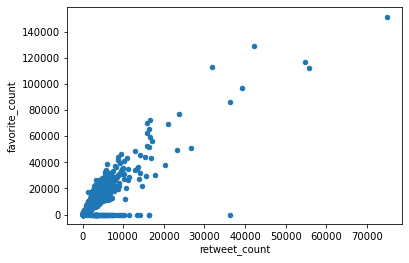

In [57]:
df_twitter_archive_dogs_only.plot.scatter(x='retweet_count', y='favorite_count');

We can notice that there is a correlation between the number of favorite and the number of retweet.
### Dog stages

In [58]:
dogs_with_stage = df_twitter_archive_dogs_only[~df_twitter_archive_dogs_only.dog_stage.isna()]
dog_stage_ratio = dogs_with_stage.shape[0] / df_twitter_archive_dogs_only.shape[0]
print("There are {:.1f}% of the tweets, predicted as dogs, were the user gave the stage of his dog.".format(dog_stage_ratio * 100))

There are 15.0% of the tweets, predicted as dogs, were the user gave the stage of his dog.


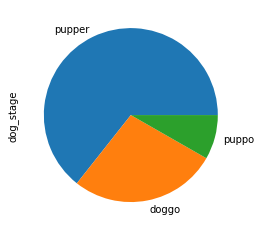

In [59]:
dogs_with_stage.dog_stage.value_counts().plot.pie();

Out of those dog with a given stage, we can notice that there are mostly some Puppers.